In [15]:
import psfam
import numpy as np
import dense_ev
import warnings
#from dense_ev import *
#import pylab
from qiskit.visualization import plot_histogram, circuit_drawer
from psfam.pauli_organizer import *
from qiskit.opflow import PauliSumOp, SummedOp, AbelianGrouper
from qiskit.opflow import Z2Symmetries
from dense_ev.dense_grouper import DenseGrouper
from dense_ev.dense_pauli_expectation import DensePauliExpectation
from qiskit.opflow.expectations import PauliExpectation
from qiskit.opflow.list_ops import ComposedOp
from qiskit.quantum_info import SparsePauliOp
import matplotlib.pyplot as plt
import copy
from qiskit import *
from qiskit import BasicAer, Aer
from qiskit_nature.drivers import Molecule
from qiskit_nature.settings import settings
#settings.dict_aux_operators = False
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import minimum_eigen_solvers, VQE
from qiskit.algorithms.minimum_eigensolvers import MinimumEigensolver
from qiskit_nature.circuit.library import HartreeFock, UCCSD
#from qiskit_nature.components.variational_forms import UCCSD
from qiskit_nature.second_q.drivers.pyscfd import pyscfdriver
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.opflow import TwoQubitReduction
from qiskit_nature.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA, POWELL, AQGD, CG, L_BFGS_B, ADAM, NELDER_MEAD, NFT
from qiskit import IBMQ, QuantumCircuit
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import Parameter
import qiskit.tools.jupyter
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit.providers.fake_provider import FakeManila, FakeCairo, FakeAuckland, FakeSherbrooke
from qiskit_aer.noise import NoiseModel
from qiskit.utils.mitigation import CompleteMeasFitter
%qiskit_job_watcher
%matplotlib inline

distances = np.arange(0.1, 0.9, 0.05)
vqe_energies = []
hf_energies = []
exact_energies = []
Delta_gs = []
backend0 = BasicAer.get_backend("statevector_simulator")
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMProvider()
backend1 = provider.get_backend('ibm_algiers')
backend2 = Aer.get_backend('qasm_simulator')
device = FakeSherbrooke()
NOISE_MODEL = NoiseModel.from_backend(device)
coupling_map = device.coupling_map
qi = QuantumInstance(backend = backend2, noise_model = NOISE_MODEL, coupling_map = coupling_map, shots=1)
optimizer = COBYLA(maxiter = 1000)

warnings.filterwarnings('ignore', category=DeprecationWarning)

#for i,d in enumerate(distances):
#    print('step', i)
    
    #setup the experiment
    
    
molecule = Molecule(geometry=[["H", [0.0, 0.0, 0.0]],["H",[0.74, 0.0, 0.0]]],
        multiplicity=1,  # = 2*spin + 1
        charge=0)
    
driver = ElectronicStructureMoleculeDriver(molecule=molecule, basis="sto3g", 
                                               driver_type=ElectronicStructureDriverType.PYSCF)
qmolecule = driver.run()

num_particles = (qmolecule.get_property("ParticleNumber").num_particles)
num_spin_orbitals = int(qmolecule.get_property("ParticleNumber").num_spin_orbitals)
    
    
    
problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(freeze_core=True)])

operator = problem.second_q_ops()
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles
    
mapper = ParityMapper()
hamiltonian = operator['ElectronicEnergy']
converter = QubitConverter(mapper, two_qubit_reduction=False, z2symmetry_reduction=None)
qubit_op = converter.convert(hamiltonian)
#z2_symmetries = Z2Symmetries.find_Z2_symmetries(qubit_op)
#symmetry = Z2Symmetries(symmetries=z2_symmetries.symmetries,sq_paulis=z2_symmetries.sq_paulis,sq_list=z2_symmetries.sq_list)
#reducer = TwoQubitReduction(num_particles)
#qubit_op = reducer.convert(qubit_op)
#qubit_op = symmetry.taper(qubit_op)
#grouper = AbelianGrouper(traverse=True)
#qubit_op = grouper.convert(qubit_op)

#Exact Result
    
solver = NumPyMinimumEigensolverFactory()
calc = GroundStateEigensolver(converter, solver)
result = calc.solve(problem)
hf_energies.append(result.hartree_fock_energy)
exact_energy = result.total_energies[0].real
log_energy = np.log(abs(exact_energy))
exact_energies.append(exact_energy)

#VQE
    
initial_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    
#qu = QuantumRegister(qubit_op.num_qubits)
#qc = QuantumCircuit(qu)

ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state=initial_state)

    
#ansatz0 = EfficientSU2(qubit_op.num_qubits, su2_gates=['rx','rz'], entanglement="linear", reps=1)

#params = [Parameter(r'$\theta_1$'), Parameter(r'$\theta_2$'), Parameter(r'$\theta_3$'), Parameter(r'$\theta_4$'),
#                 Parameter(r'$\theta_5$'),Parameter(r'$\theta_6$'),Parameter(r'$\theta_7$'),Parameter(r'$\theta_8$')]
#params2 = [Parameter(r'$\theta_9$'), Parameter(r'$\theta_{10}$'), Parameter(r'$\theta_{11}$'), Parameter(r'$\theta_{12}$'),
#                 Parameter(r'$\theta_{13}$'),Parameter(r'$\theta_{14}$'),Parameter(r'$\theta_{15}$'),Parameter(r'$\theta_{16}$')]


#qc.u(np.pi/2,params[0],params[1],0)
#qc.u(np.pi/2,params[2],params[3],1)
#qc.u(np.pi/2,params[4],params[5],2)
#qc.u(np.pi/2,params[6],params[7],3)
#qc.cx(0,1)
#qc.cx(2,3)
#qc.u(np.pi/2,params2[0],params2[1],0)
#qc.u(np.pi/2,params2[2],params2[3],1)
#qc.u(np.pi/2,params2[4],params2[5],2)
#qc.u(np.pi/2,params2[6],params2[7],3)



#ansatz1 = TwoLocal(qubit_op.num_qubits, 'rx', 'cx', 'linear', reps=1)

vqe = VQE(ansatz, optimizer, quantum_instance=qi, expectation=PauliExpectation(group_paulis=True))
vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
vqe_result = problem.interpret(vqe_calc).total_energies[0].real
log_vqe_result = np.log(abs(vqe_result))
vqe_energies.append(vqe_result)
Delta_gs.append(abs(exact_energy-vqe_result)/abs(exact_energy))

print(qubit_op.num_qubits, Delta_gs)
    
#parameters = list(ansatz.parameters)
#circuits = vqe.construct_expectation(parameters, qubit_op, return_expectation=True)
#for circuit in circuits:
#    circuit = circuit.decompose()
#    print(circuit)


    
#plt.plot(distances, exact_energies, label = 'Exact Energy')
#plt.plot(distances, vqe_energies, label = 'VQE Energy')
#plt.plot(distances, Delta_gs, label = 'Delta_gs')
#plt.legend()
#plt.show()


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

10 [0.0138767959317111]


In [352]:
print(z2_symmetries)

Z2 symmetries:
Symmetries:
IIIIIIZIIIII
IIZIZIIIZIZI
IIZZIIIIZZII
IZZIIZIZZIIZ
ZIIIIIIIIIII
Single-Qubit Pauli X:
IIIIIIXIIIII
IIIIIIIIIIXI
IIIIIIIIIXII
IIIIIIIIIIIX
XIIIIIIIIIII
Cliffords:
0.7071067811865475 * IIIIIIZIIIII
+ 0.7071067811865475 * IIIIIIXIIIII
0.7071067811865475 * IIZIZIIIZIZI
+ 0.7071067811865475 * IIIIIIIIIIXI
0.7071067811865475 * IIZZIIIIZZII
+ 0.7071067811865475 * IIIIIIIIIXII
0.7071067811865475 * IZZIIZIZZIIZ
+ 0.7071067811865475 * IIIIIIIIIIIX
0.7071067811865475 * ZIIIIIIIIIII
+ 0.7071067811865475 * XIIIIIIIIIII
Qubit index:
[5, 1, 2, 0, 11]
Tapering values:
  - Possible values: [1, 1, 1, 1, 1], [1, 1, 1, 1, -1], [1, 1, 1, -1, 1], [1, 1, 1, -1, -1], [1, 1, -1, 1, 1], [1, 1, -1, 1, -1], [1, 1, -1, -1, 1], [1, 1, -1, -1, -1], [1, -1, 1, 1, 1], [1, -1, 1, 1, -1], [1, -1, 1, -1, 1], [1, -1, 1, -1, -1], [1, -1, -1, 1, 1], [1, -1, -1, 1, -1], [1, -1, -1, -1, 1], [1, -1, -1, -1, -1], [-1, 1, 1, 1, 1], [-1, 1, 1, 1, -1], [-1, 1, 1, -1, 1], [-1, 1, 1, -1, -1], [-1, 1, -1, 

In [133]:
help(converter)

Help on QubitConverter in module qiskit_nature.converters.second_quantization.qubit_converter object:

class QubitConverter(builtins.object)
 |  QubitConverter(mapper: qiskit_nature.mappers.second_quantization.qubit_mapper.QubitMapper, two_qubit_reduction: bool = False, z2symmetry_reduction: Union[str, List[int], NoneType] = None)
 |  
 |  A converter from Second-Quantized to Qubit Operators.
 |  
 |  This converter can be configured with a mapper instance which will later be used
 |  when 2nd quantized operators are requested to be converted (mapped) to qubit operators.
 |  
 |  For a Fermionic system, when its a electronic problem, there are certain mappers, such as
 |  the :class:`~qiskit_nature.mappers.second_quantization.ParityMapper` that introduces known
 |  symmetries, by virtue of the mapping, that can be exploited to reduce the size of the
 |  problem, i.e the qubit operator, by two qubits. The two qubit reduction setting indicates
 |  to do this where possible - i.e. mapper 

In [187]:
from psfam import *
PO = PauliOrganizer(qubit_op.num_qubits)
fam = PO.get_families()
for f in fam:
    print(f)

IIXZ,XXZX,XXYY,XZXI,XZIZ,IYYX,IYZY,YXXI,YXIZ,ZIYX,ZIZY,ZYII,ZYXZ,YZZX,YZYY
XXIY,IXYI,XIYY,IZXX,XYXZ,IYZX,XZZZ,YIIX,ZXIZ,YXYX,ZIYZ,YZXI,ZYXY,YYZI,ZZZY
IXXZ,IXYX,IIZY,XYXX,XZIY,XZZI,XYYZ,YXII,YIXZ,YIYX,YXZY,ZZXX,ZYIY,ZYZI,ZZYZ
IXXY,IXZX,IIYZ,XZXX,XYIZ,XYYI,XZZY,ZXII,ZIXY,ZIZX,ZXYZ,YYXX,YZIZ,YZYI,YYZY
IXIY,XIZI,XXZY,IZIX,IYIZ,XZZX,XYZZ,YIXI,YXXY,ZIYI,ZXYY,YZXX,YYXZ,ZZYX,ZYYZ
XIIZ,XXYI,IXYZ,IZXI,XZXZ,XYZI,IYZZ,ZIXX,YIXY,YXZX,ZXZY,ZZIX,YZIY,YYYX,ZYYY
XXXZ,XIZX,IXYY,XYIX,IZXY,IYZI,XZYZ,YXXX,ZIIY,ZXYI,YIZZ,ZZXI,YYIZ,YZYX,ZYZY
XIIY,XXZI,IXZY,IYXI,XYXY,XZYI,IZYY,YIXX,ZIXZ,ZXYX,YXYZ,YYIX,ZYIZ,ZZZX,YZZZ
XXIZ,IXZI,XIZZ,IYXX,XZXY,IZYX,XYYY,ZIIX,YXIY,ZXZX,YIZY,ZYXI,YZXZ,ZZYI,YYYZ
IXIZ,XIYI,XXYZ,IYIX,IZIY,XYYX,XZYY,ZIXI,ZXXZ,YIZI,YXZZ,ZYXX,ZZXY,YYZX,YZZY
XIXZ,IIYX,XIZY,XZII,IZXZ,XZYX,IZZY,YXIX,ZXXY,YXYI,ZXZZ,ZYIX,YYXY,ZYYI,YYZZ
IIXY,XXYX,XXZZ,XYXI,XYIY,IZZX,IZYZ,ZXXI,ZXIY,YIZX,YIYZ,YZII,YZXY,ZYYX,ZYZZ
XXXY,XIYX,IXZZ,XZIX,IYXZ,IZYI,XYZY,ZXXX,YIIZ,YXZI,ZIYY,YYXI,ZZIY,ZYZX,YZYZ
XIXY,IIZX,XIYZ,XYII,IYXY,

In [242]:
import time
from qiskit.algorithms.optimizers import QNSPSA, P_BFGS, TNC
#fidelity = QNSPSA.get_fidelity(ansatz)
grouper = AbelianGrouper(traverse=True)
qubit_op = grouper.convert(qubit_op)
start = time.time()

optimizers = [COBYLA(maxiter=1000), CG(maxiter=1000), SLSQP(maxiter=1000)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    algorithm_globals.random_seed = 50
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state=initial_state)
#    ansatz0 = EfficientSU2(qubit_op.num_qubits, su2_gates=['ry','rz'], entanglement="full", reps=1)
#    ansatz1 = TwoLocal(qubit_op.num_qubits, 'rx', 'cx', 'linear', reps=1)

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
              quantum_instance=backend2, expectation=PauliExpectation(group_paulis=True))
    vqe_result = problem.interpret(vqe.compute_minimum_eigenvalue(qubit_op)).electronic_energies[0].real
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
#print(result.electronic_energies[0].real, converge_vals[i])
print('\rOptimization complete      ');
end = time.time()
print((end-start),"s")

Optimization complete      
0.30118513107299805 s


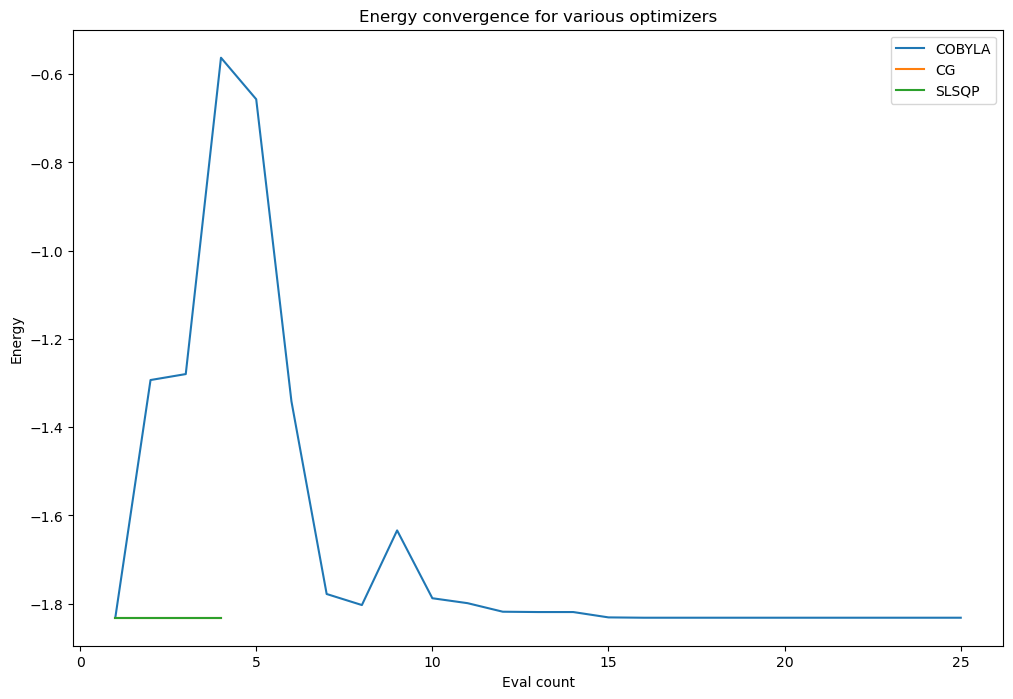

In [243]:
import pylab
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

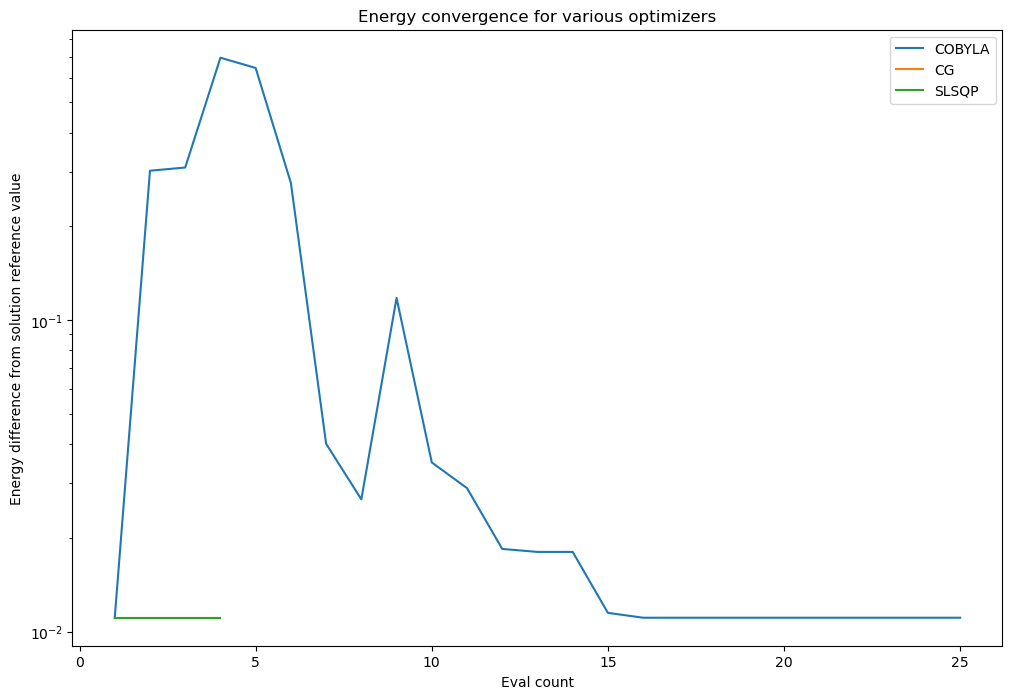

In [244]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], abs(result.electronic_energies[0].real - converge_vals[i])/abs(result.electronic_energies[0].real), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right');



Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
2
0.4639039550550785
1.5250678425194395
1.5946667271521295
1.3975281327883415
1.1527516864326945
0.9236628214196092
0.8311946521004865
0.7709729424291302
0.7211768726439011
0.6413468157749194


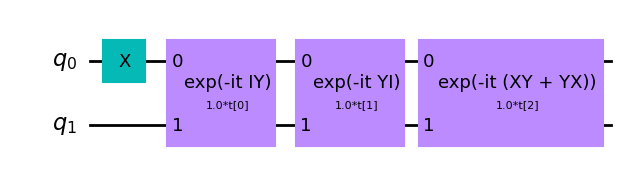

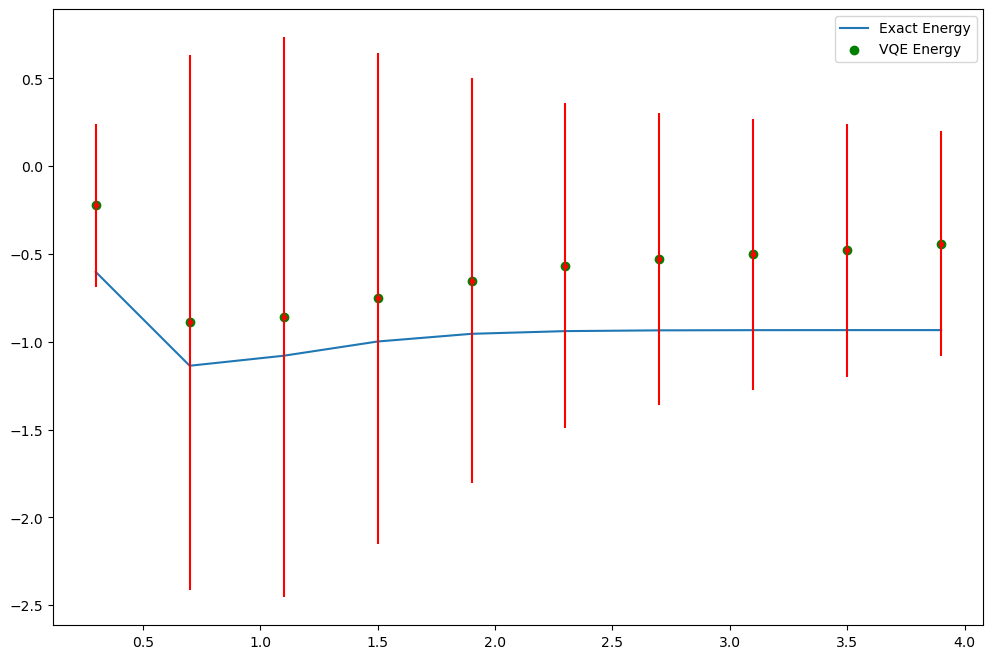

In [331]:
import numpy as np
import warnings
#import pylab
from qiskit.tools.visualization import plot_histogram, circuit_drawer
import matplotlib.pyplot as plt
import copy
from qiskit import *
from qiskit import BasicAer, Aer
from qiskit_nature.drivers import Molecule
from qiskit_nature.settings import settings
settings.dict_aux_operators = True
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.opflow import AbelianGrouper, PauliExpectation
from qiskit.algorithms import minimum_eigen_solvers, VQE
from qiskit.algorithms.minimum_eigensolvers import MinimumEigensolver
from qiskit_nature.circuit.library import HartreeFock, UCCSD
#from qiskit_nature.components.variational_forms import UCCSD
from qiskit_nature.second_q.drivers.pyscfd import pyscfdriver
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.opflow import TwoQubitReduction
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA, POWELL, AQGD
from qiskit import IBMQ, QuantumCircuit
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import Parameter
import qiskit.tools.jupyter
from qiskit.circuit.library import EfficientSU2
from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel
from qiskit.utils.mitigation import CompleteMeasFitter
%qiskit_job_watcher
%matplotlib inline

distances = np.arange(0.3, 4, 0.4)
vqe_energies = []
hf_energies = []
exact_energies = []
Delta_gs = []
backend0 = BasicAer.get_backend("statevector_simulator")
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMProvider()
backend1 = provider.get_backend('ibm_brisbane')
backend2 = Aer.get_backend('qasm_simulator')
device = FakeManila()
NOISE_MODEL = NoiseModel.from_backend(device)
coupling_map = device.configuration().coupling_map
qi = QuantumInstance(backend = backend2, noise_model = NOISE_MODEL, coupling_map = coupling_map,
                     measurement_error_mitigation_cls = CompleteMeasFitter)
optimizer = COBYLA(maxiter = 1000)
warnings.filterwarnings('ignore', category=DeprecationWarning)

for i,d in enumerate(distances):
    print('step', i)
    
    #setup the experiment
    
    
    molecule = Molecule(geometry=[["H", [0.0, 0.0, 0.0]],["H", [d, 0.0, 0.0]]],
        multiplicity=1,  # = 2*spin + 1
        charge=0)
    
    driver = ElectronicStructureMoleculeDriver(molecule=molecule, basis="sto3g", 
                                               driver_type=ElectronicStructureDriverType.PYSCF)
    qmolecule = driver.run()

    num_particles = (qmolecule.get_property("ParticleNumber").num_particles)
    num_spin_orbitals = int(qmolecule.get_property("ParticleNumber").num_spin_orbitals)
    
    
    
    problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(freeze_core=True)])

    operator = problem.second_q_ops()
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    mapper = ParityMapper()
    hamiltonian = operator['ElectronicEnergy']
#z2_symmetries = Z2Symmetries.find_Z2_symmetries(hamiltonian)
#symmetry = Z2Symmetries(symmetries=z2_symmetries.symmetries,sq_paulis=z2_symmetries.sq_paulis,sq_list=z2_symmetries.sq_list)
    converter = QubitConverter(mapper, two_qubit_reduction=True)
    qubit_op = converter.convert(hamiltonian)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = reducer.convert(qubit_op)
#qubit_op = symmetry.taper(qubit_op)
    grouper = DenseGrouper(traverse=True)
    qubit_op = grouper.convert(qubit_op)

#Exact Result
    
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    hf_energies.append(result.hartree_fock_energy)
    exact_energy = result.total_energies[0].real
    log_energy = np.log(abs(exact_energy))
    exact_energies.append(exact_energy)

#VQE
    
    initial_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    
#    qu = QuantumRegister(qubit_op.num_qubits)
#    qc = QuantumCircuit(qu)

    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state=initial_state)
    
#    ansatz0 = EfficientSU2(qubit_op.num_qubits, su2_gates=['rx','ry'], entanglement="linear", reps=1)

#    params = [Parameter(r'$\theta_1$'), Parameter(r'$\theta_2$'), Parameter(r'$\theta_3$'), Parameter(r'$\theta_4$'),
#                 Parameter(r'$\theta_5$'),Parameter(r'$\theta_6$'),Parameter(r'$\theta_7$'),Parameter(r'$\theta_8$')]
#    params2 = [Parameter(r'$\theta_9$'), Parameter(r'$\theta_{10}$'), Parameter(r'$\theta_{11}$'), Parameter(r'$\theta_{12}$'),
#                 Parameter(r'$\theta_{13}$'),Parameter(r'$\theta_{14}$'),Parameter(r'$\theta_{15}$'),Parameter(r'$\theta_{16}$')]
    
    #qc.u(np.pi/2,params[0],params[1],0)
    #qc.u(np.pi/2,params[2],params[3],1)
    #qc.u(np.pi/2,params[4],params[5],2)
    #qc.u(np.pi/2,params[6],params[7],3)
    #qc.cx(0,1)
    #qc.u(np.pi/2,params2[0],params2[1],0)
    #qc.u(np.pi/2,params2[2],params2[3],1)
    #qc.u(np.pi/2,params2[4],params2[5],2)
    #qc.u(np.pi/2,params2[6],params2[7],3)
    
#    qc.u(np.pi/2,params[0],params[1],0)
#    qc.u(np.pi/2,params[2],params[3],1)
#    qc.cx(0,1)
#    qc.u(np.pi/2,params2[0],params2[1],0)
#    qc.u(np.pi/2,params2[2],params2[3],1)

 #   ansatz1 = qc

    vqe = VQE(ansatz, optimizer, quantum_instance=qi, expectation=DensePauliExpectation())
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    log_vqe_result = np.log(abs(vqe_result))
    vqe_energies.append(vqe_result)
    Delta_gs.append(abs(np.log((exact_energy-vqe_result)/exact_energy)))
    
print(qubit_op.num_qubits)
for x in Delta_gs:
    print(x)

parameters = list(ansatz.parameters)
circuits = vqe.construct_circuit(parameters, qubit_op)
for circuit in circuits:
    circuit = circuit.decompose()
    display(circuit.draw('mpl'))

    
plt.plot(distances, exact_energies, label = 'Exact Energy')
plt.scatter(distances, vqe_energies,label = 'VQE Energy', color="g")
plt.errorbar(distances, vqe_energies, yerr = Delta_gs, fmt=".", color="r")
#plt.plot(distances, Delta_gs, label = 'Delta_gs')
plt.legend()
plt.show()


In [ ]:
help(DensePauliExpectation)